In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

_BATCH_NORM_DECAY = 0.997
_BATCH_NORM_EPSILON = 1e-5

def batch_norm(inputs, training):
  return tf.layers.batch_normalization(
      inputs=inputs, axis=3,
      momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON, center=True,
      scale=True, training=training, fused=True)

def fixed_padding(inputs, kernel_size):
  """Pads the input along the spatial dimensions independently of input size."""
  pad_total = kernel_size - 1
  pad_beg = pad_total // 2
  pad_end = pad_total - pad_beg

  padded_inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end],
                                    [pad_beg, pad_end], [0, 0]])
  return padded_inputs


def conv2d_fixed_padding(inputs, filters, kernel_size, strides):
  """Strided 2-D convolution with explicit padding."""
  if strides > 1:
    inputs = fixed_padding(inputs, kernel_size)

  return tf.layers.conv2d(
      inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides,
      padding=('SAME' if strides == 1 else 'VALID'), use_bias=False,
      kernel_initializer=tf.variance_scaling_initializer())

def resnetUnit(input, filters, kernel_size, strides, bottleneck, training):
  """A resnet50 unit with two branches."""
  shortcut = input
  if bottleneck:
    shortcut = conv2d_fixed_padding(
      inputs=shortcut, filters=filters[2], strides=strides[2], kernel_size=kernel_size[2])
    shortcut = batch_norm(shortcut, training)
  
  input = conv2d_fixed_padding(
      inputs=input, filters=filters[0], strides=strides[0], kernel_size=kernel_size[0])
  input = batch_norm(input, training)
  input = conv2d_fixed_padding(
      inputs=input, filters=filters[1], strides=strides[1], kernel_size=kernel_size[1])
  input = batch_norm(input, training)
  
  return tf.nn.relu(input + shortcut)
  

def resnet50(features, labels, mode):
  training = (mode == tf.estimator.ModeKeys.TRAIN)

  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  #input_layer = tf.reshape(features["x"], [-1, 224, 224, 3])
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])


  # Convolutional Layer #1
  conv1 = conv2d_fixed_padding(
      inputs=input_layer, filters=64, strides=2, kernel_size=7)
  conv1_norm = batch_norm(conv1, training)
  conv1_relu = tf.nn.relu(conv1_norm)
  pool1 = tf.layers.max_pooling2d(
    inputs=conv1_relu, pool_size=3, strides=2, padding='SAME',
    data_format='channels_last')
  
  kernel_size = [3, 3, 3]
  filters_2 = [64, 64, 64]
  strides_2 = [1, 1, 1]
  
  #res2a
  res2a_relu = resnetUnit(pool1, filters_2, kernel_size, strides_2,
                          bottleneck = True, training = training)
  res2b_relu = resnetUnit(res2a_relu, filters_2, kernel_size, strides_2,
                          bottleneck = False, training = training)
  
  filters_3 = [128, 128, 128]
  strides_3 = [2, 1, 2]
  res3a_relu = resnetUnit(res2b_relu, filters_3, kernel_size, strides_3,
                          bottleneck = True, training = training)
  res3b_relu = resnetUnit(res3a_relu, filters_3, kernel_size, strides_2,
                          bottleneck = False, training = training)

  
  filters_4 = [256, 256, 256]
  res4a_relu = resnetUnit(res3b_relu, filters_4, kernel_size, strides_3,
                          bottleneck = True, training = training)
  res4b_relu = resnetUnit(res4a_relu, filters_4, kernel_size, strides_2,
                          bottleneck = False, training = training)  

  
  filters_5 = [512, 512, 512]
  res5a_relu = resnetUnit(res4b_relu, filters_5, kernel_size, strides_3,
                          bottleneck = True, training = training)
  res5b_relu = resnetUnit(res5a_relu, filters_5, kernel_size, strides_2,
                          bottleneck = False, training = training)

  # ResNet does an Average Pooling layer over pool_size.
  # Do a reduce_mean because it performs better than AveragePooling2D.
  axes = [1, 2]
  inputs = tf.reduce_mean(res5b_relu, axes, keepdims=True)
  inputs = tf.reshape(inputs, [-1, 1*1*512])
  
  #dense = tf.layers.dense(inputs=inputs, units=1000, activation=tf.nn.relu)
  dropout = tf.layers.dropout(inputs=inputs, rate=0.5, training=training)

  logits = tf.layers.dense(inputs=inputs, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  accuracy = tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
  
  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
  

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = { "accuracy": accuracy }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


def main(unused_argv):
  # Load training and eval data
  mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  train_data = mnist.train.images  # Returns np.array
  train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
  eval_data = mnist.test.images  # Returns np.array
  eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

  # Create the Estimator
  mnist_classifier = tf.estimator.Estimator(
      model_fn=resnet50, model_dir="/model-18/test3")

  # Set up logging for predictions
  # Log the values in the "Softmax" tensor with label "probabilities"
  tensors_to_log = {"probabilities": "softmax_tensor"}
  logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=200)

  # Train the model
  train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
  mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1000,
    hooks=[logging_hook])
  
  eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
  eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
  print(eval_results)
  
"""
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=100,
    hooks=[logging_hook])
"""
"""
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)A
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)
"""
  
if __name__ == "__main__":
  tf.app.run()


Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-u

INFO:tensorflow:loss = 0.31495294, step = 100 (7.496 sec)
INFO:tensorflow:global_step/sec: 14.211
INFO:tensorflow:probabilities = [[0.00000048 0.00000094 0.00000003 0.00000053 0.00000006 0.00000005
  0.00000003 0.9999814  0.00000003 0.00001637]
 [0.0014146  0.0013982  0.00004365 0.00068974 0.00030502 0.00153045
  0.00049855 0.99289846 0.00004037 0.001181  ]
 [0.00058155 0.00010927 0.00004542 0.00057027 0.00010857 0.9973327
  0.00062227 0.00002124 0.00036811 0.0002406 ]
 [0.00917264 0.00954074 0.41130206 0.01413023 0.02118727 0.00243764
  0.00569834 0.03773679 0.48188755 0.00690671]
 [0.00088956 0.98930943 0.00099481 0.00136454 0.00150778 0.00054622
  0.00134465 0.00096037 0.00083972 0.00224291]
 [0.00000043 0.00000255 0.00006136 0.9999043  0.00000171 0.00001851
  0.00000587 0.00000147 0.00000277 0.00000109]
 [0.00120316 0.00078805 0.00007235 0.0000448  0.00674133 0.00005733
  0.00502811 0.00027583 0.00511304 0.98067605]
 [0.3405091  0.00091703 0.01245863 0.20921987 0.00141338 0.1562201

INFO:tensorflow:loss = 0.23432699, step = 400 (7.045 sec)
INFO:tensorflow:global_step/sec: 14.1784
INFO:tensorflow:loss = 0.17376311, step = 500 (7.037 sec)
INFO:tensorflow:global_step/sec: 14.2035
INFO:tensorflow:probabilities = [[0.00012366 0.00023606 0.01206912 0.00023929 0.00019864 0.00012467
  0.00025803 0.00004385 0.98661345 0.00009323]
 [0.00212927 0.018101   0.01507948 0.01406756 0.00467816 0.0141933
  0.00239066 0.9163059  0.00001504 0.0130396 ]
 [0.00631481 0.0009478  0.00158323 0.00304979 0.0005462  0.00121214
  0.00148083 0.0000832  0.98304474 0.00173716]
 [0.00007932 0.00094908 0.00003326 0.00018178 0.99807596 0.00001781
  0.00000807 0.00018367 0.00001177 0.00045917]
 [0.00173329 0.00036375 0.00194705 0.00077519 0.0012771  0.00040152
  0.00037971 0.00958751 0.97213656 0.01139842]
 [0.00000013 0.00000006 0.00000002 0.00000004 0.00002732 0.00000009
  0.00000009 0.00013054 0.00000053 0.9998412 ]
 [0.00000409 0.00000979 0.00000292 0.00005137 0.9984137  0.00000106
  0.00004398 

INFO:tensorflow:loss = 0.09220714, step = 800 (7.060 sec)
INFO:tensorflow:global_step/sec: 14.1765
INFO:tensorflow:loss = 0.05243266, step = 900 (7.038 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /model-18/test3/model.ckpt.
INFO:tensorflow:Loss for final step: 0.06438368.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-04-21:30:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /model-18/test3/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-04-21:30:29
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.2144, global_step = 1000, loss = 2.277051
{'accuracy': 0.2144, 'loss': 2.277051, 'global_step': 1000}


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Extracting input/data/train-images-idx3-ubyte.gz
Extracting input/data/train-labels-idx1-ubyte.gz
Extracting input/data/t10k-images-idx3-ubyte.gz
Extracting input/data/t10k-labels-idx1-ubyte.gz
(55000, 784)


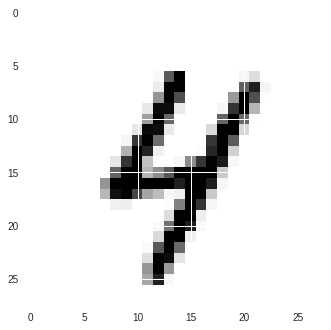

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

# Import Fashion MNIST
fashion_mnist = input_data.read_data_sets('input/data', one_hot=False)
sample_1 = fashion_mnist.train.images[47].reshape(28,28)
# Get corresponding integer label from one-hot encoded data
#sample_label_1 = np.where(fashion_mnist.train.labels[47] == 1)[0][0]
# Plot sample
#print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')
print(fashion_mnist.train.images.shape)